###### The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 1: Wine quality classification with K-NN


**Student ID(s):** `1269602`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **


## 1. K-NN classifier


In [174]:
import os
import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.spatial.distance import cdist

# Create directory to store results/images
directory = 'results'
if not os.path.exists(directory):
    os.makedirs(directory)

class KNNClassifier:
    def __init__(self, k, distance_metric="euclidean", weighting=None, debug=False):
        self.k = k
        self.debug = debug
        self.distance_metric = distance_metric
        self.weighting = weighting

    def distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(x1 - x2)
        elif self.distance_metric == 'cosine':
            return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
        elif self.distance_metric == 'mahalanobis':
            return np.sqrt(np.dot(np.dot((x1 - x2), self.inv_covariance_matrix), (x1 - x2)))

    def weight(self, d):
        if self.weighting == 'inverse':
            return 1 / (d + 1e-6)
        else:
            return 1

    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values

        # Compute the inverse covariance matrix for Mahalanobis distance
        if self.distance_metric == 'mahalanobis':
            self.inv_covariance_matrix = np.linalg.inv(np.cov(self.X_train.T))

    def predict(self, X_test):
        predictions = []
        X_test = X_test.values
        for x_test in X_test:
            # Compute distances to all training samples
            distances = cdist([x_test], self.X_train, metric=self.distance_metric).ravel()

            # Sort distances and indices to get nearest neighbors
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]

            if not self.weighting:
                # Majority voting
                prediction = Counter(nearest_labels).most_common(1)[0][0]
            else:
                # Compute weights for nearest neighbors
                weights = np.array([self.weight(distances[i]) for i in nearest_indices])
                weighted_counts = np.bincount(nearest_labels, weights=weights, minlength=2)
                # Predict the label with the highest weighted count
                prediction = np.argmax(weighted_counts)

            predictions.append(prediction)

        return predictions


In [182]:
from tabulate import tabulate

def reportToTable(report, max_support):
    '''
    Helper function to convert a classification report from sklearn into a readable table from tabulate
    '''
    # Convert report to table
    table = []
    for label, metrics in report.items():
        if label == 'accuracy':
            accuracy = round(metrics, 2)  # Round accuracy to two decimal places
            table.append(['accuracy', '', '', accuracy, max_support])
        else:
            precision = round(metrics['precision'], 2)  # Round precision to two decimal places
            recall = round(metrics['recall'], 2)  # Round recall to two decimal places
            f1_score = round(metrics['f1-score'], 2)  # Round F1-score to two decimal places
            table.append([label, precision, recall, f1_score, metrics['support']])

    table = tabulate(table, headers=['Class', 'Precision', 'Recall', 'F1-score', 'Support'], tablefmt='grid')
    return table

In [177]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("winequality-train.csv")
test_df = pd.read_csv("winequality-test.csv")

# Separate features and class for training df
X_train = train_df.drop(columns=['quality'])
y_train = train_df['quality']

# Separate features and class for testing df
X_test = test_df.drop(columns=['quality'])
y_test = test_df['quality']


Accuracy: 74.15%


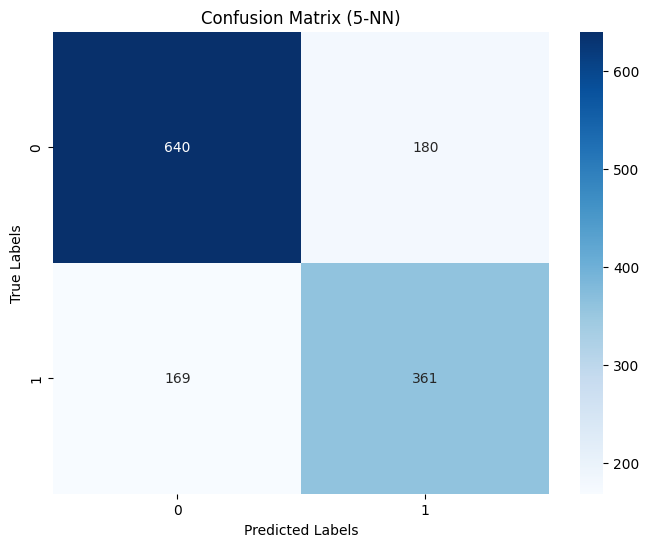

In [192]:
# Initiate the KNN classifier and fit it to the training data 
knn = KNNClassifier(k=5, debug=False)
knn.fit(X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the test data
predictions = knn.predict(X_test)
true_labels = y_test

# Get Classification Report
report = classification_report(true_labels, predictions, output_dict=True)
table = reportToTable(report, len(X_train))

# Save classification report table to a file
report_file_path = os.path.join(directory, '5-NN_classification_report.txt')
with open(report_file_path, 'w') as file:
    file.write(table)

# Print Accuracy
accuracy = report['accuracy']
print(f"\nAccuracy: {round(accuracy * 100, 2)}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot and save confusion matrix
confusion_matrix_file_path = os.path.join(directory, '5-NN_confusion_matrix.png')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (5-NN)')
plt.savefig(confusion_matrix_file_path)


## 2. 1-NN classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.



Accuracy: 76.44%


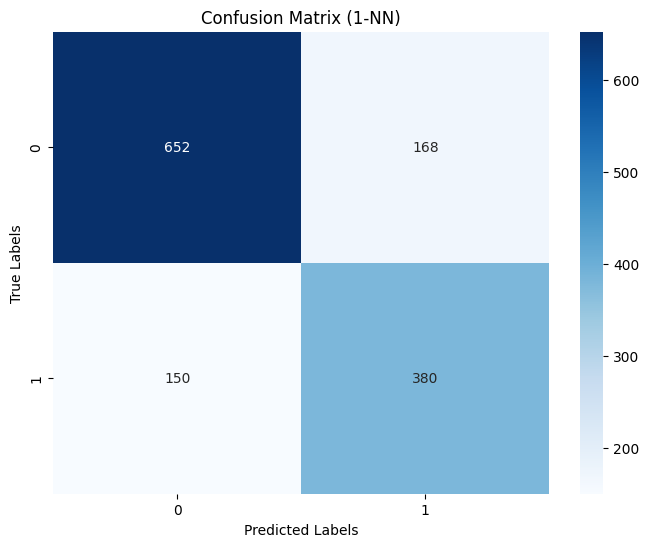

In [194]:
# Initiate 1-NN classifier and fit it to the training data 
knn = KNNClassifier(k=1, debug=False)
knn.fit(X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the test data
predictions = knn.predict(X_test)
true_labels = y_test

# Get Classification Report
report = classification_report(true_labels, predictions, output_dict=True)
table = reportToTable(report, len(X_train))

# Save classification report table to a file
report_file_path = os.path.join(directory, '1-NN_classification_report.txt')
with open(report_file_path, 'w') as file:
    file.write(table)

# Print Accuracy
accuracy = report['accuracy']
print(f"\nAccuracy: {round(accuracy * 100, 2)}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot and save confusion matrix
confusion_matrix_file_path = os.path.join(directory, '1-NN_confusion_matrix.png')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (1-NN)')
plt.savefig(confusion_matrix_file_path)

Is this dataset suitable for 1-NN classification? 

Attributes: fixedAcidity, volatileAcidity, citricAcid, residualSugar, chlorides, freeSulfurDioxide, totalSulfurDioxide, density, pH, sulphates, alcohol, quality

Considerations for 1-NN Classifiers: The bias is low and variance is high. The probability of modelling the noise in the training data is high. 

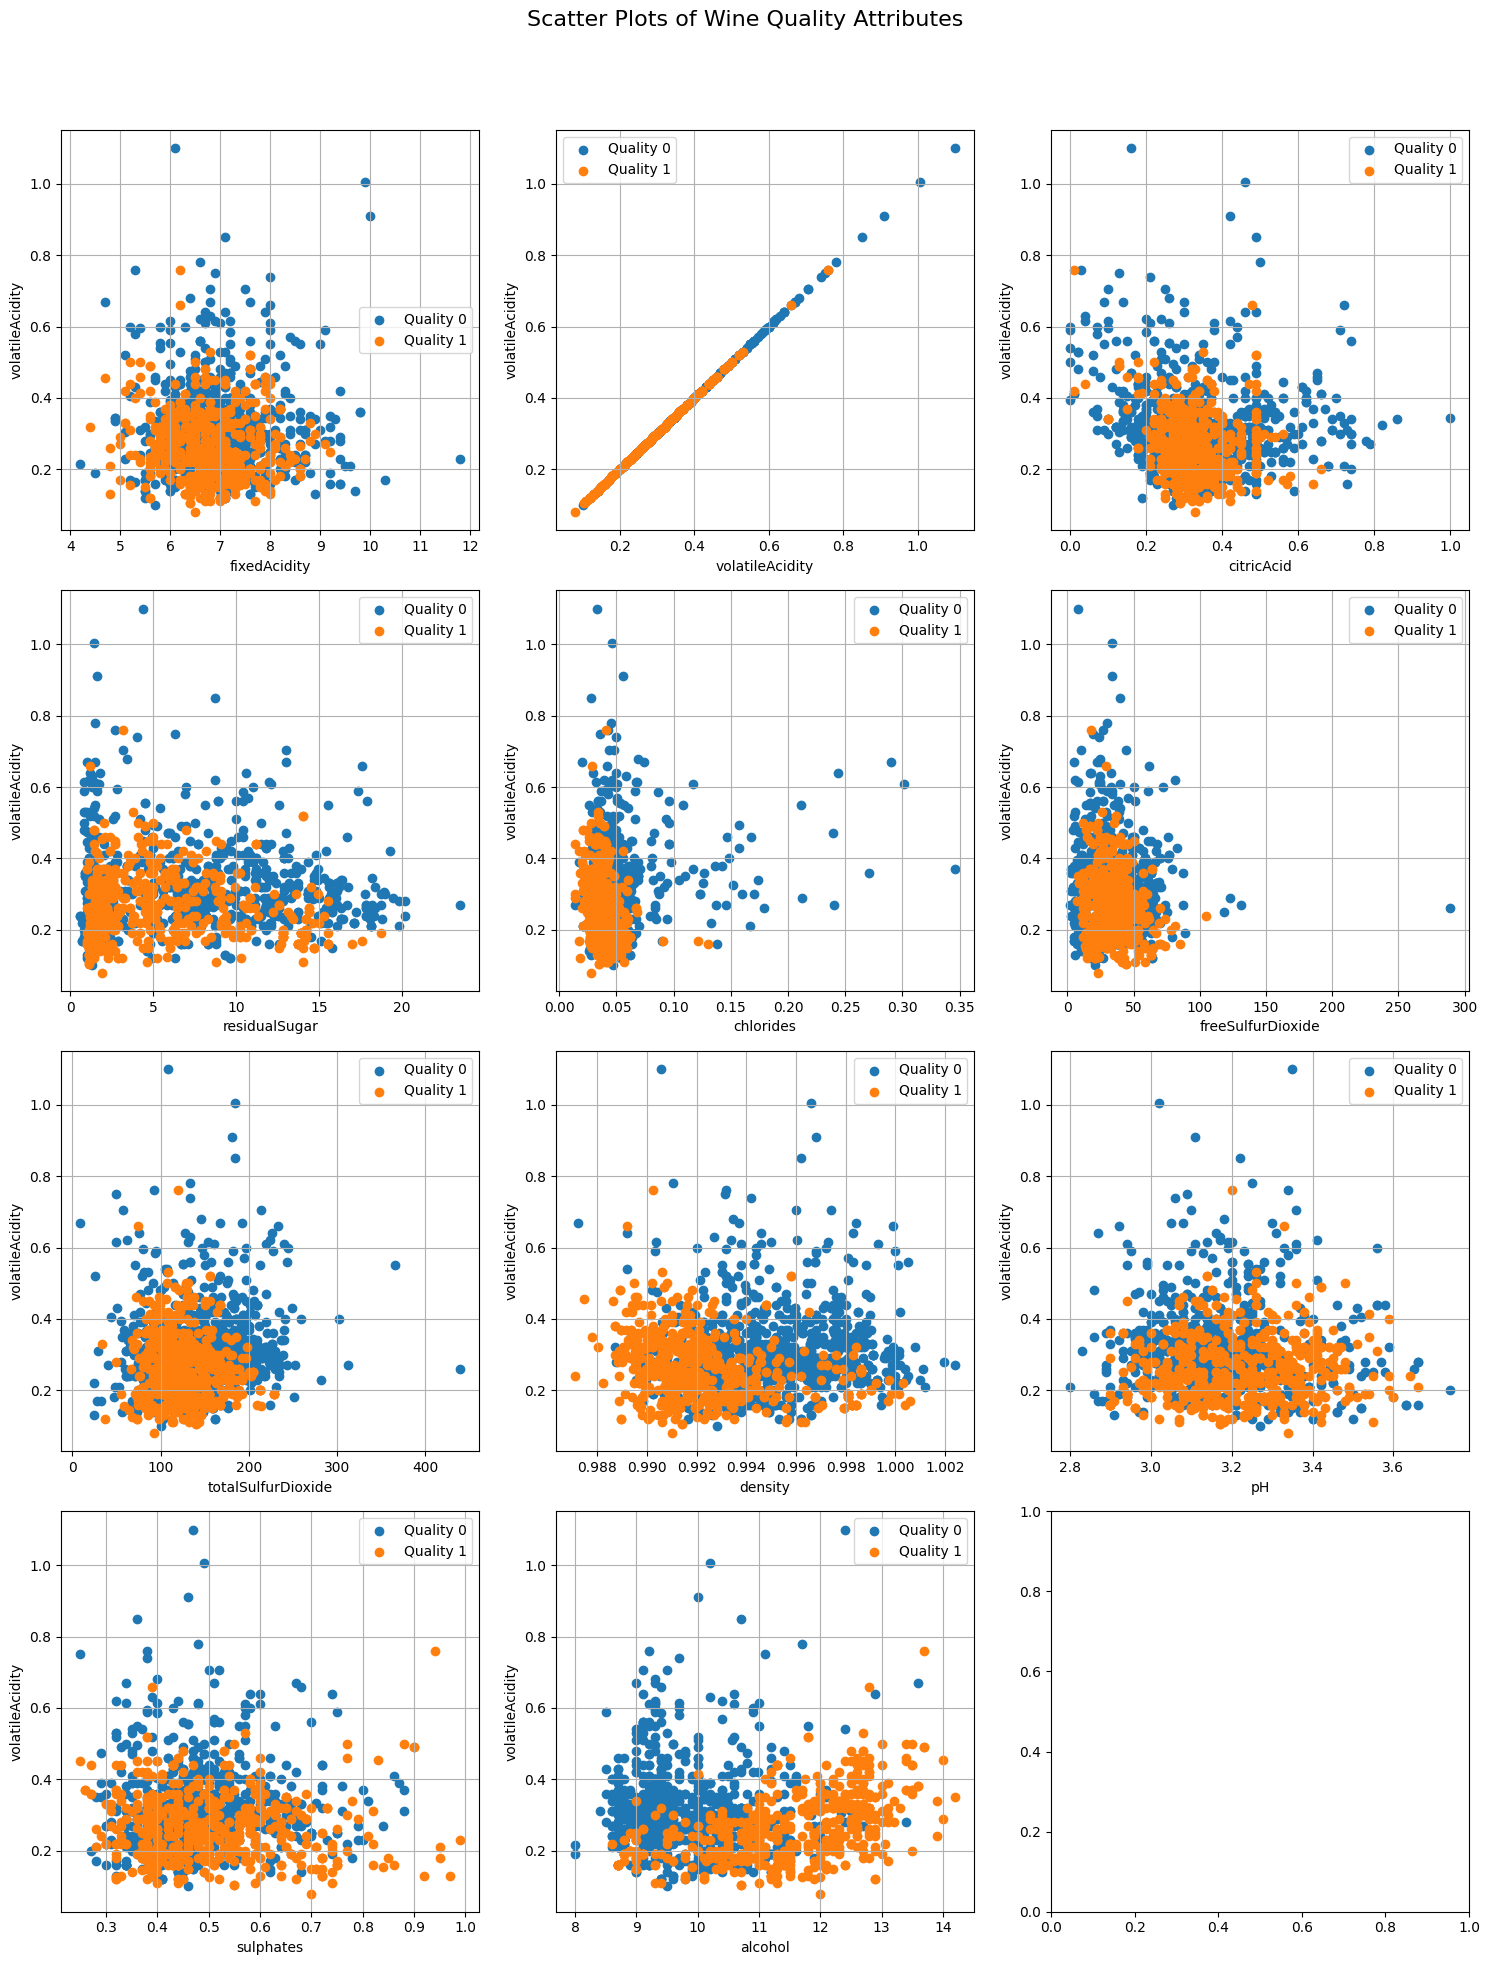

In [216]:
# Define attributes
attributes = ['fixedAcidity', 'volatileAcidity', 'citricAcid', 'residualSugar', 'chlorides','freeSulfurDioxide', 'totalSulfurDioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Define quality levels
quality_levels = train_df['quality'].unique()

# Set up subplots
num_plots = len(attributes)
num_cols = 3 
num_rows = (num_plots + num_cols - 1) // num_cols

# Choose the second attribute for the scatter plots
attribute2 = 'volatileAcidity'

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
fig.suptitle('Scatter Plots of Wine Quality Attributes', fontsize=16)

# Flatten axes if necessary
if num_plots > 1:
    axes = axes.flatten()

# Plot for each attribute
for i, attribute in enumerate(attributes):
    row = i // num_cols
    col = i % num_cols
    ax = axes[i]
    
    # Plot each quality level separately
    for quality_level in quality_levels:
        ax.scatter(train_df[train_df['quality'] == quality_level][attribute], 
                train_df[train_df['quality'] == quality_level][attribute2], 
                label=f'Quality {quality_level}')
    
    ax.set_xlabel(attribute)
    ax.set_ylabel(attribute2)
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## 3. Normalization

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


1. Min-max scale all attributes to the range 0 − 1: 
    $x′ = \frac{x−min(x)}{max(x)−min(x)}$

In [195]:
def min_max_scaling(train_df, test_df):
    scaled_train_df = train_df.copy()
    scaled_test_df = test_df.copy()

    for col in train_df.columns:
        min_val = train_df[col].min()
        max_val = train_df[col].max()

        scaled_train_df[col] = (train_df[col] - min_val) / (max_val - min_val)
        scaled_test_df[col] = (test_df[col] - min_val) / (max_val - min_val)

    return scaled_train_df, scaled_test_df

scaled_train_df, scaled_test_df = min_max_scaling(train_df, test_df)
scaled_X_train = scaled_train_df.drop(columns=['quality'])
scaled_X_test = scaled_test_df.drop(columns=['quality'])


Accuracy: 85.04%


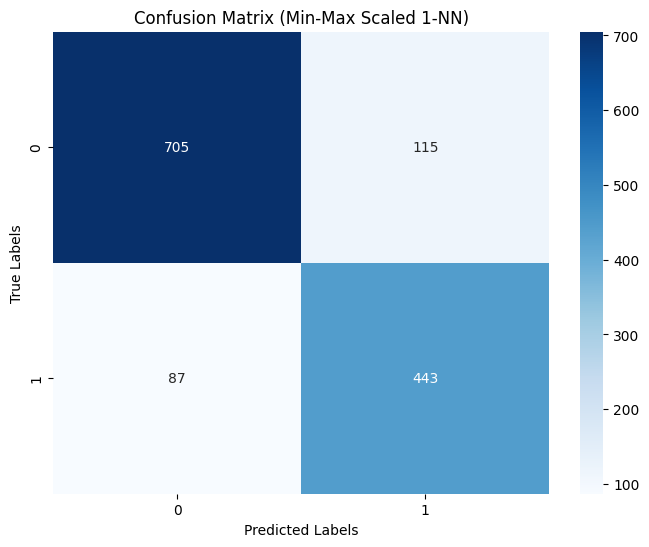

In [208]:
# Initiate 1-NN classifier and fit it to the scaled training data 
knn = KNNClassifier(k=1, debug=False)
knn.fit(scaled_X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the scaled test data
predictions = knn.predict(scaled_X_test)
true_labels = y_test

# Get Classification Report
report = classification_report(true_labels, predictions, output_dict=True)
table = reportToTable(report, len(scaled_X_train))

# Save classification report table to a file
report_file_path = os.path.join(directory, 'minmax_scaled_1-NN_classification_report.txt')
with open(report_file_path, 'w') as file:
    file.write(table)

# Print Accuracy
accuracy = report['accuracy']
print(f"\nAccuracy: {round(accuracy * 100, 2)}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot and save confusion matrix
confusion_matrix_file_path = os.path.join(directory, 'minmax_scaled_1-NN_confusion_matrix.png')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Min-Max Scaled 1-NN)')
plt.savefig(confusion_matrix_file_path)

2. Standardize all attributes to have mean of 0 and standard deviation of 1
    $x′ = \frac{x−mean(x)}{stdev(x)}$

In [79]:
def standardize(train_df, test_df):
    standardized_train_df = train_df.copy()
    standardized_test_df = test_df.copy()

    mean_vals = train_df.mean()
    std_vals = train_df.std()

    for col in train_df.columns:
        standardized_train_df[col] = (train_df[col] - mean_vals[col]) / std_vals[col]
        standardized_test_df[col] = (test_df[col] - mean_vals[col]) / std_vals[col]

    return standardized_train_df, standardized_test_df

standardized_train_df, standardized_test_df = standardize(train_df, test_df)
standardized_X_train = standardized_train_df.drop(columns=['quality'])
standardized_X_test = standardized_test_df.drop(columns=['quality'])


Accuracy: 86.74%


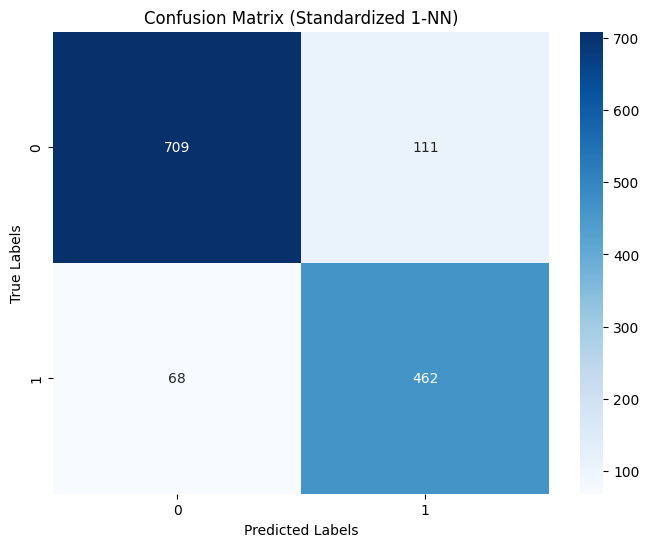

In [207]:
# Initiate 1-NN classifier and fit it to the standardized training data 
knn = KNNClassifier(k=1, debug=False)
knn.fit(standardized_X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the standardized test data
std_predictions = knn.predict(standardized_X_test)
true_labels = y_test

# Get classification report
report = classification_report(true_labels, std_predictions, output_dict=True)
table = reportToTable(report, len(standardized_X_train))

# Save report table as file
report_file_path = os.path.join(directory, 'standardized_1-NN_classification_report.txt')
with open(report_file_path, 'w') as file:
    file.write(table)

# Print Accuracy
accuracy = report['accuracy']
print(f"\nAccuracy: {round(accuracy * 100, 2)}%")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, std_predictions)

# Plot and save confusion matrix
confusion_matrix_file_path = os.path.join(directory, 'standardized_1-NN_confusion_matrix.png')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Standardized 1-NN)')
plt.savefig(confusion_matrix_file_path)


## 4. Model extensions

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


### 4.1

Compare the performance of your best 1-NN model from Question 3 to a Gaussian naive Bayes model on this dataset (you may use library functions to implement the Gaussian naive Bayes model). In your write-up, state the accuracy of the naive Bayes model and identify instances where the two models disagree. Why do the two models classify these instances differently?


In [133]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_y_pred = gnb.predict(X_test)
acc = gnb.score(X_test, y_test)

results_df = pd.DataFrame({'Predicted_GNB': gnb_y_pred, 'Predicted_1NN': std_predictions, 'True Label': y_test})

print(results_df)
print(f"GNB Accuracy: {round(acc*100, 2)}%")

inconsistent_cases = results_df[results_df['Predicted_GNB'] != results_df['Predicted_1NN']]

# Select rows from X_test corresponding to the inconsistent indices
inconsistent_indices = inconsistent_cases.index
inconsistent_X_test = X_test.iloc[inconsistent_indices]

# Print the selected rows
print()
print("Rows of X_test corresponding to inconsistent predictions:")
print(inconsistent_X_test)

      Predicted_GNB  Predicted_1NN  True Label
0                 1              0           0
1                 0              0           0
2                 1              1           1
3                 1              1           1
4                 1              1           1
...             ...            ...         ...
1345              1              1           1
1346              1              1           1
1347              1              1           0
1348              0              0           0
1349              1              1           1

[1350 rows x 3 columns]
GNB Accuracy: 77.78%

Rows of X_test corresponding to inconsistent predictions:
      fixedAcidity  volatileAcidity  citricAcid  residualSugar  chlorides  \
0              8.1            0.270        0.41           1.45      0.033   
9              6.2            0.160        0.33           1.10      0.057   
18             7.4            0.250        0.37          13.50      0.060   
19             7.4     

### 4.2

Implement two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance (you may use library functions for these distance measures). Do 1-NN classification using each of these new distance measures and the three normalization options from Question 3. Discuss how the new distance metrics compare to Euclidean distance and how each metric is affected by normalization.


In [99]:
distances = {'euclidean': [], 'cosine': [], 'mahalanobis': []}

for dist in distances.keys():
    knn = KNNClassifier(k=1, distance_metric=dist)
    accuracies = []

    # no normalization
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = round(np.mean(predictions == y_test) * 100, 2)   
    
    # min-max normalization
    knn.fit(scaled_X_train, y_train)
    predictions_min_max = knn.predict(scaled_X_test)
    accuracy_min_max = round(np.mean(predictions_min_max == y_test) * 100, 2)


    # euclidean - standardized normalization 
    knn.fit(standardized_X_train, y_train)
    predictions_std = knn.predict(standardized_X_test)
    accuracy_std = round(np.mean(predictions_std == y_test) * 100, 2)

    # append accuracies 
    accuracies.append(accuracy)
    accuracies.append(accuracy_min_max)
    accuracies.append(accuracy_std)

    distances[dist] = accuracies


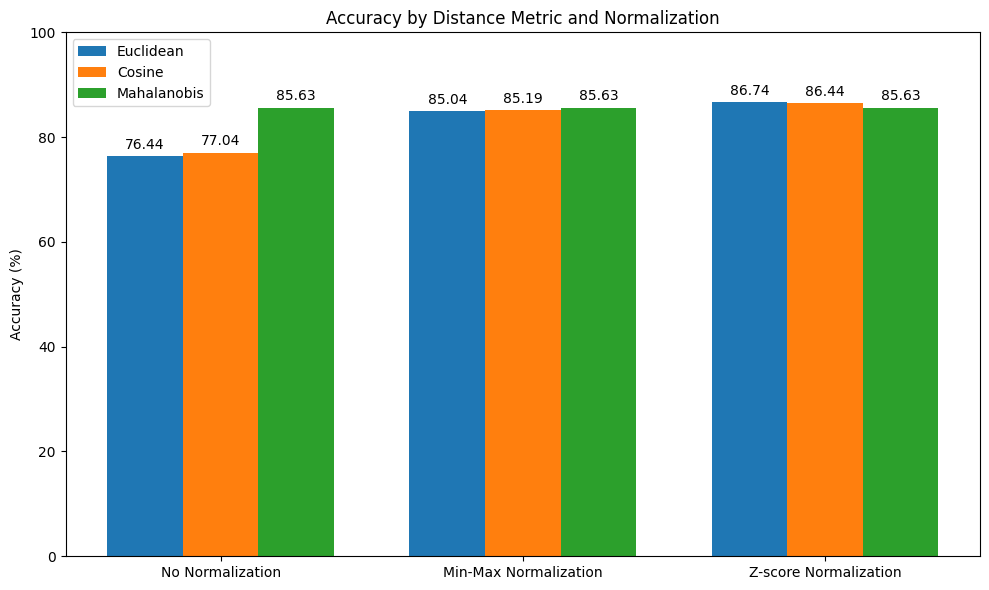

In [205]:
# Visualise this information
# Labels
labels = ['No Normalization', 'Min-Max Normalization', 'Z-score Normalization']

# Plot
x = np.arange(len(labels)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, distances['euclidean'], width, label='Euclidean')
rects2 = ax.bar(x, distances['cosine'], width, label='Cosine')
rects3 = ax.bar(x + width, distances['mahalanobis'], width, label='Mahalanobis')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by Distance Metric and Normalization')
ax.set_xticks(x)
ax.set_ylim(0, 100) 
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

fig.tight_layout()

plt.savefig(f'{directory}/distance_metric_accuracy_plot.png')

plt.show()

### 4.3

Implement either of the two K-NN weighting strategies discussed in lecture (inverse linear distance or inverse distance). Compare the performance of the weighted and majority vote models for a few different values of K. In your write-up, discuss how weighting strategy and the value of K affect the model's decisions.


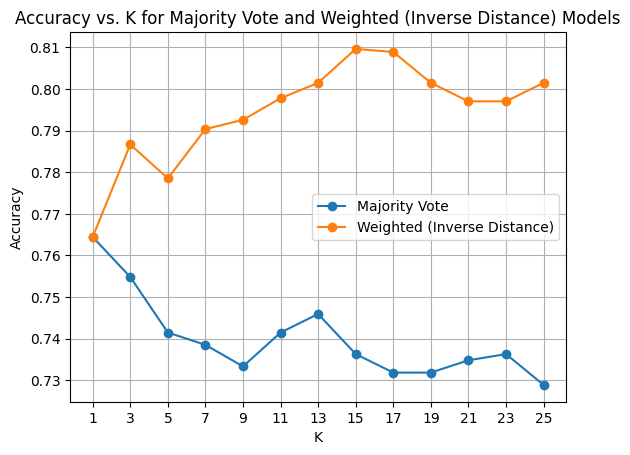

In [209]:
import matplotlib.pyplot as plt

# Define values of K to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

# Initialize lists to store accuracy scores
accuracy_majority_list = []
accuracy_weighted_inverse_list = []

# Iterate over each value of K
for k in k_values:
    # Majority vote model
    knn_majority = KNNClassifier(k=k)
    knn_majority.fit(X_train, y_train)
    predictions_majority = knn_majority.predict(X_test)
    accuracy_majority = np.mean(predictions_majority == y_test)
    accuracy_majority_list.append(accuracy_majority)

    # Weighted model with inverse distance
    knn_weighted_inverse = KNNClassifier(k=k, weighting='inverse')
    knn_weighted_inverse.fit(X_train, y_train)
    predictions_weighted_inverse = knn_weighted_inverse.predict(X_test)
    accuracy_weighted_inverse = np.mean(predictions_weighted_inverse == y_test)
    accuracy_weighted_inverse_list.append(accuracy_weighted_inverse)

# Plotting
plt.plot(k_values, accuracy_majority_list, marker='o', label='Majority Vote')
plt.plot(k_values, accuracy_weighted_inverse_list, marker='o', label='Weighted (Inverse Distance)')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K for Majority Vote and Weighted (Inverse Distance) Models')
plt.xticks(k_values)
plt.legend()
plt.grid(True)

plt.savefig(f'{directory}/weighting_accuracy_plot.png')

plt.show()


### 4.4

Measure the empirical distribution of class labels in the training dataset (what percentage of the training data comes from each class). Then evaluate the distribution of labels predicted by your K-NN model for the test data, for a range of values for K. Does the class distribution of the predicted labels match the class distribution of the training data? Explain why or why not.


In [212]:
# Step 1: Calculate empirical distribution of class labels in the training dataset
def calculate_class_distribution(y):
    class_counts = Counter(y)
    total_samples = len(y)
    class_distribution = {label: count / total_samples for label, count in class_counts.items()}
    return class_distribution

# Empirical distribution of class labels in the training dataset
train_class_distribution = calculate_class_distribution(y_train)
print("Empirical Distribution of Class Labels in the Training Dataset:")
print(train_class_distribution)

# Empirical distribution of class labels in the testing dataset
test_class_distribution = calculate_class_distribution(y_test)
print("\nEmpirical Distribution of Class Labels in the Testing Dataset:")
print(test_class_distribution)

# Step 2-4: Evaluate the distribution of predicted labels for different values of K
k_values = [1, 3, 5, 7, 9]
test_predicted_class_distributions = []

for k in k_values:
    # Train K-NN model
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    
    # Predict labels for the test data
    predictions = knn.predict(X_test)
    
    # Calculate the distribution of predicted labels
    predicted_class_distribution = calculate_class_distribution(predictions)
    test_predicted_class_distributions.append(predicted_class_distribution)

# Print the distributions of predicted labels for different values of K
for i, k in enumerate(k_values):
    print(f"\nDistribution of Predicted Labels for K = {k}:")
    print(test_predicted_class_distributions[i])


Empirical Distribution of Class Labels in the Training Dataset:
{0: 0.6074074074074074, 1: 0.3925925925925926}

Empirical Distribution of Class Labels in the Testing Dataset:
{0: 0.6074074074074074, 1: 0.3925925925925926}

Distribution of Predicted Labels for K = 1:
{0: 0.5940740740740741, 1: 0.4059259259259259}

Distribution of Predicted Labels for K = 3:
{0: 0.6081481481481481, 1: 0.39185185185185184}

Distribution of Predicted Labels for K = 5:
{0: 0.5992592592592593, 1: 0.40074074074074073}

Distribution of Predicted Labels for K = 7:
{0: 0.5933333333333334, 1: 0.4066666666666667}

Distribution of Predicted Labels for K = 9:
{0: 0.6014814814814815, 1: 0.3985185185185185}


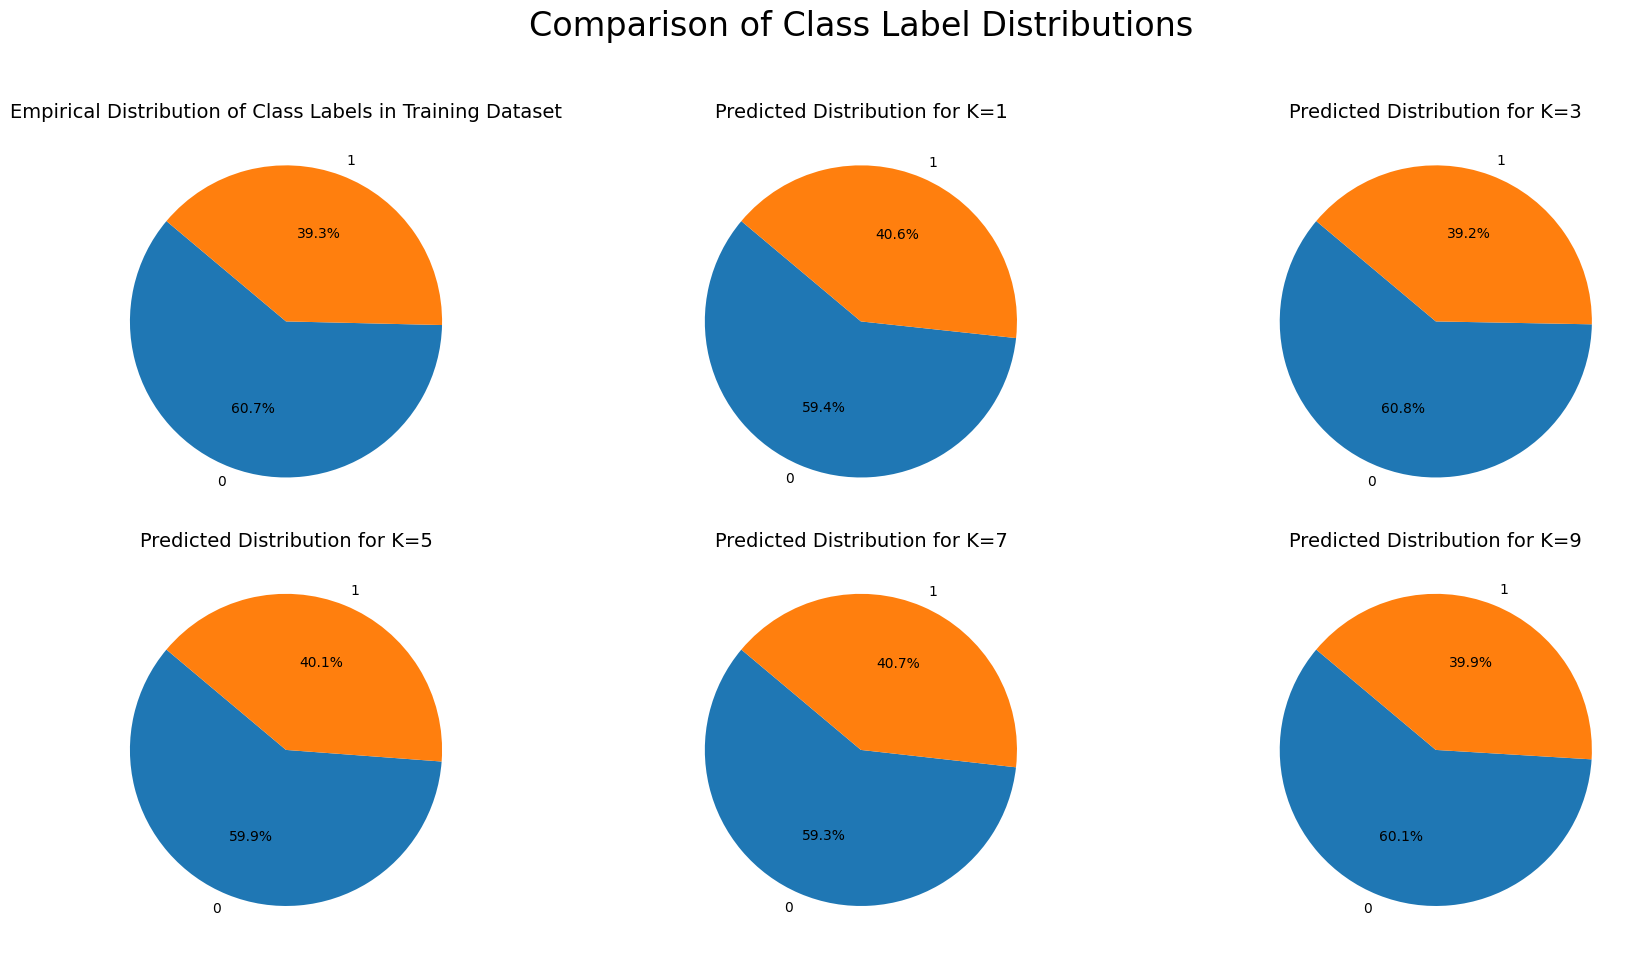

In [213]:
import matplotlib.pyplot as plt

# Plotting the distributions
plt.figure(figsize=(18, 10))

# Add a title to the overall plot
plt.suptitle('Comparison of Class Label Distributions', fontsize=24)

# Plot empirical distribution of class labels in the training dataset
plt.subplot(2, 3, 1)
plt.pie(train_class_distribution.values(), labels=train_class_distribution.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Empirical Distribution of Class Labels in Training Dataset', fontsize=14)

# Plot distribution of predicted labels for different values of K
for i, k in enumerate(k_values):
    plt.subplot(2, 3, i+2)
    plt.pie(test_predicted_class_distributions[i].values(), labels=test_predicted_class_distributions[i].keys(), autopct='%1.1f%%', startangle=140)
    plt.title(f'Predicted Distribution for K={k}', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f'{directory}/distributions_of_labels.png')

plt.show()
